In [1]:

import glob
import os.path
import numpy as np
import mne
import matplotlib.pyplot as plt
import pandas as pd
import yasa

import dataset

plt.style.use('default')
plt.rc('font', family='Arial')
plt.rc('axes', unicode_minus=False)

mne.set_log_level('CRITICAL')

In [2]:
df_info = dataset.load_info()

In [27]:
df_spikes = pd.read_excel(os.path.join(dataset.path['results'], 'spike_detect.xlsx'), index_col=0)

In [3]:
animals = df_info['Monkeys'].unique()

In [29]:
def hist_smooth_bin(timestamp, bin_width=10, window_step=5):
    max_len = (timestamp.max() // bin_width) * (bin_width + 1)
    start = 0
    count = []
    start_points = []
    while start < max_len:
        end = start + bin_width
        count.append(((timestamp < end) & (timestamp >= start)).sum())
        start_points.append(start)
        start += window_step

    return np.array(count), np.array(start_points)

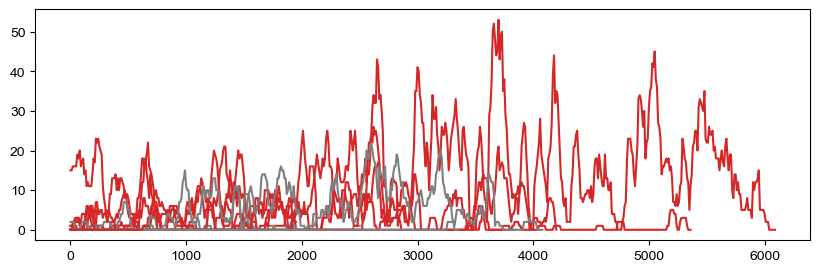

In [30]:
df_session_sr = pd.DataFrame()
plt.figure(figsize=(10, 3))

for animal in animals:
    df_spike_animal = df_spikes[df_spikes['animal_id'] == animal]
    sessions = os.listdir(os.path.join(dataset.path['tmp'], animal))
    # sessions = df_spikes[df_spikes['animal_id'] == animal]['session'].unique()

    for session in sessions:
        df_spike_session = df_spike_animal[df_spike_animal['session'] == session]
        df_session_sr_tmp = df_spike_session.loc[:0, df_spike_session.columns[:4]]
        df_spike_session = df_spike_session[(df_spike_session['isi'] < 60) & (df_spike_session['isi'] > 0)]
        df_spike_session = df_spike_session.reset_index(drop=True)
        
        if len(df_spike_session) == 0:
            spike_rate = 0
        else:
            bin_width = 60
            sr, bin_edges = hist_smooth_bin(df_spike_session['peak_onset'], bin_width=bin_width, window_step=10)
            if df_spike_session.loc[0, 'genotype'] == 'WT':
                color = 'tab:gray'
            else:
                color = 'tab:red'
            plt.plot(bin_edges, sr, color=color)

            spike_rate = df_spike_session.shape[0] / (sr > 0).sum() / bin_width

        df_session_sr_tmp.insert(df_session_sr_tmp.shape[1], 'spike_rate', spike_rate)
        df_session_sr = pd.concat([df_session_sr, df_session_sr_tmp], ignore_index=True)

In [31]:
df_session_sr

,animal_id,session,genotype,session_length,spike_rate
0,0628#,2024-03-14,WT,2481.996,0.000000
1,0629#,2024-03-29,Mutant,3633.996,0.000000
2,0633#,2024-03-09,WT,2372.996,0.000000
3,0635#,2024-05-13,Mutant,5538.996,0.011655
4,0741#,2024-03-14,Mutant,2866.996,0.020782
5,0745#,2024-04-05,WT,3645.996,0.011364
6,0760#,2024-05-24,Mutant,6867.996,0.027778
7,0767#,2024-05-16,Mutant,1792.996,0.000000
8,0769#,2024-05-11,WT,5636.996,0.000000
9,0771#,2024-03-21,Mutant,6051.996,0.039910


Text(0, 0.5, 'Spike rate (/s)')

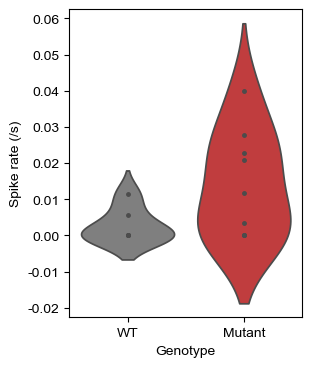

In [32]:
import seaborn as sns

plt.figure(figsize=(3, 4))
sns.violinplot(
    data=df_session_sr,
    x='genotype',
    y='spike_rate',
    hue='genotype',
    hue_order=['WT', 'Mutant'],
    palette=['tab:gray', 'tab:red'],
    inner="point"
)
plt.xlabel('Genotype')
plt.ylabel('Spike rate (/s)')

In [33]:
from scipy.stats import levene, ttest_ind, ranksums

group_A = df_session_sr.loc[df_session_sr['genotype'] == 'WT', 'spike_rate']
group_B = df_session_sr.loc[df_session_sr['genotype'] == 'Mutant', 'spike_rate']
# _, p_square = levene(group_A, group_B)
# _, p = ttest_ind(group_A, group_B, equal_var=p_square > 0.05)
stat, p = ranksums(group_A, group_B)
print(f'P value: {p:.2f}')

P value: 0.13
